<a href="https://colab.research.google.com/github/toahniwalmanan/City-Facts/blob/main/Air_Quality_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install lightgbm

In [ ]:
# @title Default title text
variable_name = "" # @param {"type":"string"}
import os, sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import matplotlib.pyplot as plt

print("Python:", sys.version.splitlines()[0], "Pandas:", pd.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0] Pandas: 2.2.2


In [ ]:
csv_path = "/content/data_date.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print(df.head())

date_col = None
for c in df.columns:
    if 'date' in c.lower() or 'time' in c.lower():
        date_col = c
        break
if date_col is None:
    try:
        pd.to_datetime(df[df.columns[0]])
        date_col = df.columns[0]
    except Exception:
        raise ValueError("No date-like column found - please name the date column 'Date' or 'date' or upload a CSV with a date column.")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found. Please ensure your CSV has an AQI numeric column.")

target_candidates = [c for c in df.columns if c.lower() in ('aqi','aqi value','pm2.5','pm25','pm10','air_quality','value')]
target_col = target_candidates[0] if target_candidates else numeric_cols[0]

print("Using date column:", date_col, "and target column:", target_col)

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(by=date_col).reset_index(drop=True)
print("Date range:", df[date_col].min(), "to", df[date_col].max())


Shape: (21523, 4)
         Date    Country                          Status  AQI
0  21-07-2022    Albania                            Good   14
1  21-07-2022    Algeria                        Moderate   65
2  21-07-2022    Andorra                        Moderate   55
3  21-07-2022     Angola  Unhealthy for Sensitive Groups  113
4  21-07-2022  Argentina                        Moderate   63
Using date column: Date and target column: AQI
Date range: 2022-07-21 00:00:00 to 2025-10-09 00:00:00


/tmp/ipython-input-376345425.py:27: UserWarning:

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



count    21523.000000
mean        62.393393
std         49.638291
min          1.000000
25%         29.000000
50%         52.000000
75%         82.000000
max        963.000000
Name: AQI, dtype: float64

Missing values per column:
 Date       0
Country    0
Status     0
AQI        0
dtype: int64


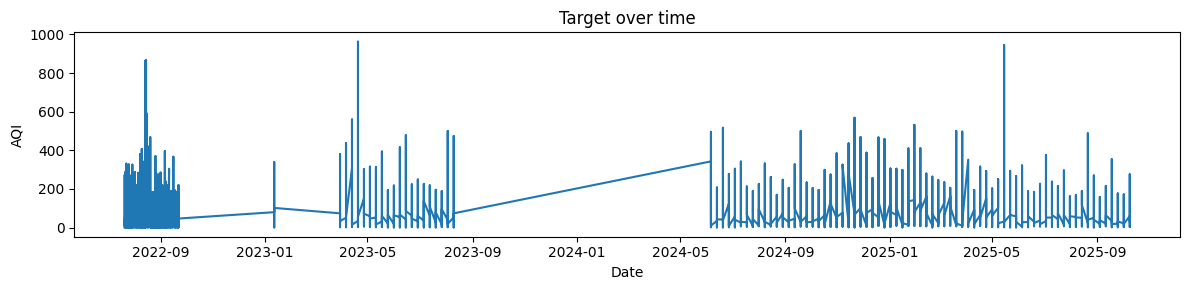

In [ ]:
print(df[target_col].describe())
print("\nMissing values per column:\n", df.isna().sum())

plt.figure(figsize=(12,3))
plt.plot(df[date_col], df[target_col])
plt.title("Target over time")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.tight_layout()
plt.show()


In [ ]:
df[target_col] = df[target_col].ffill().bfill()   # simple fill

feat = df[[date_col, target_col]].copy().set_index(date_col)
for lag in range(1, 8):
    feat[f'lag_{lag}'] = feat[target_col].shift(lag)

feat['rolling_3'] = feat[target_col].shift(1).rolling(window=3, min_periods=1).mean()
feat['rolling_7'] = feat[target_col].shift(1).rolling(window=7, min_periods=1).mean()

feat['dayofweek'] = feat.index.dayofweek
feat['day'] = feat.index.day
feat['month'] = feat.index.month

feat[target_col] = feat[target_col]

print("Features created. Example:")
print(feat.dropna().head())


Features created. Example:
            AQI  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  rolling_3  \
Date                                                                          
2022-07-21  129   13.0   73.0   25.0  161.0   16.0   80.0   14.0  37.000000   
2022-07-21    5  129.0   13.0   73.0   25.0  161.0   16.0   80.0  71.666667   
2022-07-21   41    5.0  129.0   13.0   73.0   25.0  161.0   16.0  49.000000   
2022-07-21   79   41.0    5.0  129.0   13.0   73.0   25.0  161.0  58.333333   
2022-07-21  113   79.0   41.0    5.0  129.0   13.0   73.0   25.0  41.666667   

            rolling_7  dayofweek  day  month  
Date                                          
2022-07-21  54.571429          3   21      7  
2022-07-21  71.000000          3   21      7  
2022-07-21  60.285714          3   21      7  
2022-07-21  63.857143          3   21      7  
2022-07-21  52.142857          3   21      7  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_horizon_model(dataframe, target_col, horizon=1, test_size=0.2, random_state=42, n_estimators=100):
    """
    dataframe: DataFrame indexed by date, must contain lag features and date parts (as created earlier)
    target_col: name of the original target column
    horizon: days ahead to predict (1 = next day, 7 = next week)
    """
    df_work = dataframe.copy()
    df_work['y_horizon'] = df_work[target_col].shift(-horizon)
    df_work = df_work.dropna().reset_index()
    date_col_name = df_work.columns[0]

    X = df_work.drop(columns=[date_col_name, 'y_horizon', target_col])
    y = df_work['y_horizon']
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_rmse = mean_squared_error(y_train, y_pred_train) ** 0.5
    test_rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
    metrics = {
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'n_train': len(X_train),
        'n_test': len(X_test)
    }
    return model, X_train, X_test, y_train, y_test, y_pred_test, metrics


In [ ]:
# import lightgbm as lgb
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_absolute_error
# import numpy as np

# horizon = 1
# df_work = feat.copy()
# df_work['y_horizon'] = df_work[target_col].shift(-horizon)
# df_work = df_work.dropna().reset_index()
# date_col_name = df_work.columns[0]
# X = df_work.drop(columns=[date_col_name, 'y_horizon', target_col])
# y = df_work['y_horizon'].values

# tscv = TimeSeriesSplit(n_splits=5)
# test_scores = []
# models = []

# for train_idx, val_idx in tscv.split(X):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)
#     params = {
#         'objective': 'regression',
#         'metric': 'l2',
#         'learning_rate': 0.05,
#         'num_leaves': 31,
#         'verbosity': -1,
#         'seed': 42
#     }
#     bst = lgb.train(
#     params,
#     train_data,
#     valid_sets=[val_data],
#     num_boost_round=2000,
#     callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)])

#     y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)
#     score = mean_absolute_error(y_val, y_pred)
#     test_scores.append(score)
#     models.append(bst)

# print("CV MAE scores:", test_scores)
# print("Mean CV MAE:", np.mean(test_scores))


Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 2348.99
[200]	valid_0's l2: 2337.98
Early stopping, best iteration is:
[167]	valid_0's l2: 2337.53
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 2512.15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 2574.32
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	valid_0's l2: 2995.23
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 2199.63
CV MAE scores: [32.493457722150595, 34.79660937599687, 34.86416530567106, 37.99801479184786, 32.87464248502976]
Mean CV MAE: 34.60537793613923


Next-day metrics: {'train_mae': 12.488322698449586, 'test_mae': 37.242720892400655, 'train_rmse': 17.890363043149055, 'test_rmse': 51.829818375265646, 'n_train': 17212, 'n_test': 4303}


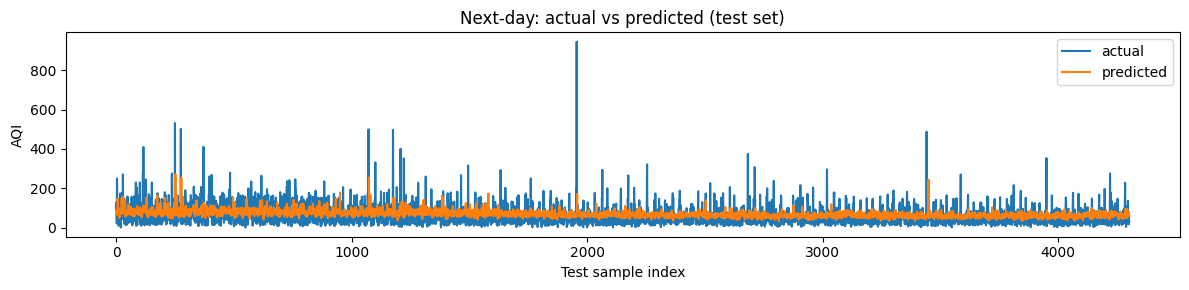

In [ ]:
model_1d, X_train_1d, X_test_1d, y_train_1d, y_test_1d, y_pred_1d, metrics_1d = train_horizon_model(feat, target_col, horizon=1)
print("Next-day metrics:", metrics_1d)

plt.figure(figsize=(12,3))
plt.plot(range(len(y_test_1d)), y_test_1d.values, label='actual')
plt.plot(range(len(y_pred_1d)), y_pred_1d, label='predicted')
plt.title("Next-day: actual vs predicted (test set)")
plt.xlabel("Test sample index")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()


Next-week metrics: {'train_mae': 12.80575728316549, 'test_mae': 37.98055649089018, 'train_rmse': 18.402473461737728, 'test_rmse': 52.30180093727835, 'n_train': 17207, 'n_test': 4302}


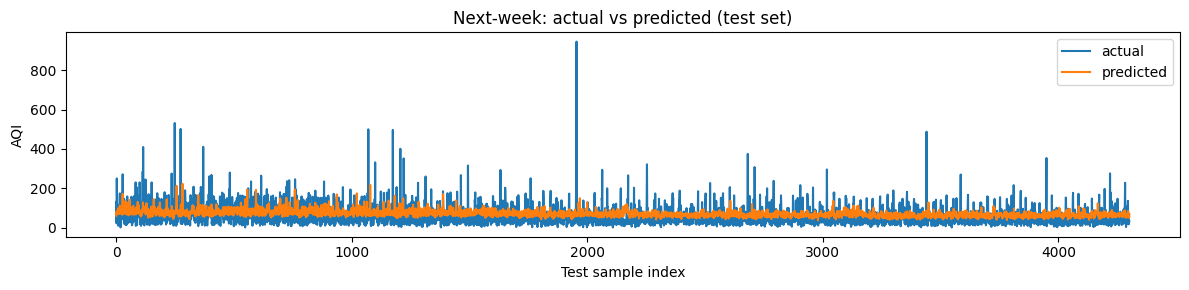

In [ ]:
model_7d, X_train_7d, X_test_7d, y_train_7d, y_test_7d, y_pred_7d, metrics_7d = train_horizon_model(feat, target_col, horizon=7)
print("Next-week metrics:", metrics_7d)

plt.figure(figsize=(12,3))
plt.plot(range(len(y_test_7d)), y_test_7d.values, label='actual')
plt.plot(range(len(y_pred_7d)), y_pred_7d, label='predicted')
plt.title("Next-week: actual vs predicted (test set)")
plt.xlabel("Test sample index")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
os.makedirs("/content/models", exist_ok=True)
joblib.dump(model_1d, "/content/models/aqi_model_next_day.joblib")
joblib.dump(model_7d, "/content/models/aqi_model_next_week.joblib")
print("Saved models to /content/models/")

last_row = feat.iloc[-1:]
example_X = last_row.drop(columns=[target_col]).ffill().bfill().iloc[0:1]
pred_next_day = model_1d.predict(example_X)[0]
pred_next_week = model_7d.predict(example_X)[0]
print("Example next-day prediction:", pred_next_day)
print("Example next-week (single-step) prediction:", pred_next_week)


Saved models to /content/models/
Example next-day prediction: 56.95
Example next-week (single-step) prediction: 74.34


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model_1d.predict(X_test_1d)

mae = mean_absolute_error(y_test_1d, y_pred)

rmse = np.sqrt(mean_squared_error(y_test_1d, y_pred))

# r2 = r2_score(y_test_1d, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
# print(f"R²   : {r2:.3f}")


MAE  : 37.243
RMSE : 51.830


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assume your dataset has 'Country' and 'AQI' columns
# df = pd.read_csv("data_date.csv")

# # Categorize AQI into levels
# def aqi_category(aqi):
#     if aqi <= 50:
#         return "Good"
#     elif aqi <= 100:
#         return "Moderate"
#     else:
#         return "Harmful"

# df["AQI_Level"] = df["AQI"].apply(aqi_category)

# # Count by country
# country_aqi = df.groupby(["Country", "AQI_Level"]).size().reset_index(name="Count")


In [ ]:
# plt.figure(figsize=(10,6))
# sns.barplot(data=country_aqi, x="Country", y="Count", hue="AQI_Level")
# plt.title("Air Quality Level by Country")
# plt.xlabel("Country")
# plt.ylabel("Number of Days")
# plt.legend(title="AQI Level")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

<Figure size 1600x800 with 0 Axes>

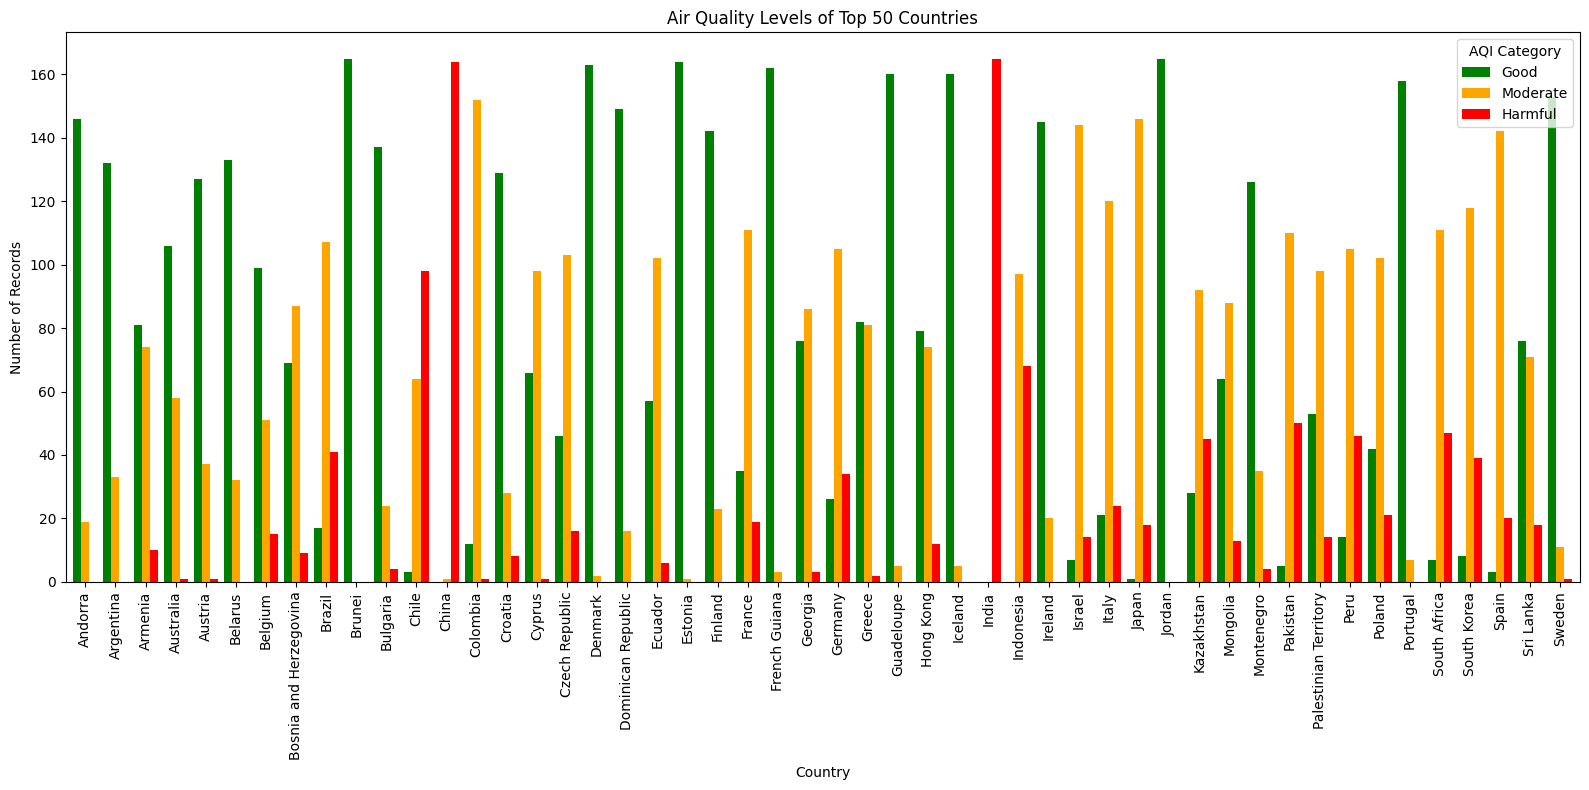

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Adjust column names if needed --------
# Check your actual column names first: print(df.columns)
country_col = "Country"   # Change if your country column name differs
aqi_col = "AQI"           # Change if your AQI column name differs

# -------- Categorize AQI levels --------
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    else:
        return "Harmful"

df["AQI_Level"] = df[aqi_col].apply(aqi_category)

# -------- Select top 50 countries by record count --------
top50 = df[country_col].value_counts().nlargest(50).index
df_top50 = df[df[country_col].isin(top50)]

# -------- Group by Country and AQI Level --------
country_aqi = (
    df_top50.groupby([country_col, "AQI_Level"])
    .size()
    .reset_index(name="Count")
)

# -------- Pivot for better visualization --------
pivot_data = country_aqi.pivot(index=country_col, columns="AQI_Level", values="Count").fillna(0)

# Ensure consistent order of categories
for level in ["Good", "Moderate", "Harmful"]:
    if level not in pivot_data.columns:
        pivot_data[level] = 0

# -------- Plotting --------
plt.figure(figsize=(16, 8))
pivot_data[["Good", "Moderate", "Harmful"]].plot(kind="bar", stacked=False, width=0.8, figsize=(16,8), color=["green", "orange", "red"])

plt.title("Air Quality Levels of Top 50 Countries")
plt.xlabel("Country")
plt.ylabel("Number of Records")
plt.xticks(rotation=90)
plt.legend(title="AQI Category")
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

country_avg = df.groupby("Country")["AQI"].mean().reset_index()
fig = px.choropleth(country_avg,
                    locations="Country",
                    locationmode="country names",
                    color="AQI",
                    color_continuous_scale="RdYlGn_r",
                    title="Average Air Quality Index by Country")
fig.show()

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # -------- Adjust column names if needed --------
# # Check your actual column names first: print(df.columns)
# country_col = "Country"   # Change if your country column name differs
# aqi_col = "AQI"           # Change if your AQI column name differs

# # -------- Step 1: Compute average AQI per country --------
# country_avg = df.groupby(country_col)[aqi_col].mean().reset_index()
# country_avg.rename(columns={aqi_col: "Average_AQI"}, inplace=True)

# # -------- Step 2: Categorize each country --------
# def aqi_category(aqi):
#     if aqi <= 50:
#         return "Good"
#     elif aqi <= 100:
#         return "Moderate"
#     else:
#         return "Harmful"

# country_avg["Category"] = country_avg["Average_AQI"].apply(aqi_category)

# # -------- Step 3: Count how many countries fall into each category --------
# category_counts = country_avg["Category"].value_counts()

# # -------- Step 4: Plot pie chart --------
# colors = ["green", "orange", "red"]
# plt.figure(figsize=(7, 7))
# plt.pie(
#     category_counts,
#     labels=category_counts.index,
#     autopct="%1.1f%%",
#     startangle=90,
#     colors=colors,
#     textprops={"fontsize": 12}
# )
# plt.title("Distribution of Countries by Air Quality Category (Average AQI)", fontsize=14)
# plt.show()

# # -------- Step 5: Display table listing countries by category --------
# good_countries = country_avg[country_avg["Category"] == "Good"][country_col].tolist()
# moderate_countries = country_avg[country_avg["Category"] == "Moderate"][country_col].tolist()
# harmful_countries = country_avg[country_avg["Category"] == "Harmful"][country_col].tolist()

# # Create table summary
# summary_table = pd.DataFrame({
#     "Good Countries": [", ".join(good_countries) if good_countries else "None"],
#     "Moderate Countries": [", ".join(moderate_countries) if moderate_countries else "None"],
#     "Harmful Countries": [", ".join(harmful_countries) if harmful_countries else "None"]
# })

# # Display the table
# print("List of Countries by Air Quality Category:\n")
# display(summary_table)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# -------- Adjust column names if needed --------
# Check your actual column names first: print(df.columns)
country_col = "Country"   # Change if your country column name differs
aqi_col = "AQI"           # Change if your AQI column name differs

# -------- Step 1: Compute average AQI per country --------
country_avg = df.groupby(country_col)[aqi_col].mean().reset_index()
country_avg.rename(columns={aqi_col: "Average_AQI"}, inplace=True)

# -------- Step 2: Categorize each country --------
def aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    else:
        return "Harmful"

country_avg["Category"] = country_avg["Average_AQI"].apply(aqi_category)

# -------- Step 3: Count how many countries fall into each category --------
category_counts = country_avg["Category"].value_counts()

# -------- Step 4: Plot pie chart --------
fig = px.pie(
    names=category_counts.index,
    values=category_counts.values,
    color=category_counts.index,
    color_discrete_map={"Good": "green", "Moderate": "orange", "Harmful": "red"},
    title="Distribution of Countries by Air Quality Category (Average AQI)"
)

# Update hover template to show exact count (not percentage)
fig.update_traces(
    textinfo="percent",
    hovertemplate="<b>%{label}</b><br>Countries: %{value}<extra></extra>"
)

# Optional layout polish
fig.update_layout(
    showlegend=True,
    legend_title_text="Air Quality",
    legend=dict(x=0.85, y=0.9)
)

fig.show()

# -------- Step 5: Display table listing countries by category --------
good_countries = country_avg[country_avg["Category"] == "Good"][country_col].tolist()
moderate_countries = country_avg[country_avg["Category"] == "Moderate"][country_col].tolist()
harmful_countries = country_avg[country_avg["Category"] == "Harmful"][country_col].tolist()

# Create table summary
summary_table = pd.DataFrame({
    "Good Countries": [", ".join(good_countries) if good_countries else "None"],
    "Moderate Countries": [", ".join(moderate_countries) if moderate_countries else "None"],
    "Harmful Countries": [", ".join(harmful_countries) if harmful_countries else "None"]
})

# Display the table
print("List of Countries by Air Quality Category:\n")
display(summary_table)

List of Countries by Air Quality Category:



,Good Countries,Moderate Countries,Harmful Countries
0,"Albania, Andorra, Argentina, Australia, Austri...","Algeria, Armenia, Belgium, Bolivia, Bosnia and...","Angola, Bahrain, Bangladesh, Central African R..."
